In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [257]:
df = pd.read_excel("../../raw_data/market_data.xlsx").loc[9:106].reset_index(drop = True)
df["Time (UTC+10)"] = pd.to_datetime(df["Time (UTC+10)"])
vicp = df["Regions VIC Trading Price ($/MWh)"]
vicd = df["Regions VIC Operational Demand (MW)"]
time = df["Time (UTC+10)"]

In [258]:
price = pd.DataFrame()
price["time"] = time
price["price"] = vicp

demand = pd.DataFrame()
demand["time"] = time
demand["demand"] = vicd

In [224]:
price

,time,price
0,2018-01-01 04:30:00,64.50
1,2018-01-01 05:00:00,65.41
2,2018-01-01 05:30:00,63.66
3,2018-01-01 06:00:00,59.90
4,2018-01-01 06:30:00,64.67
...,...,...
93,2018-01-03 03:00:00,49.37
94,2018-01-03 03:30:00,50.99
95,2018-01-03 04:00:00,52.00
96,2018-01-03 04:30:00,54.33


In [225]:
vicp

0     64.50
1     65.41
2     63.66
3     59.90
4     64.67
      ...  
93    49.37
94    50.99
95    52.00
96    54.33
97    55.38
Name: Regions VIC Trading Price ($/MWh), Length: 98, dtype: float64

In [226]:
def CMA(df, col, n):
    MA = []
    dfc = df.reset_index(drop = True)
    print(dfc)
    for i in dfc.index:
        if (i > n - 1) and i < len(df) - n:
            Period = []
            for j in range(1, n + 1):
                Period.append(df[col].loc[i - j])
                Period.append(df[col].loc[i + j])
            entry = np.mean(Period)
        else:
            entry = np.nan

        MA.append(entry)
        
    dfn = pd.DataFrame()
    dfn["MA"] = MA
    
    dff = pd.merge(dfc, dfn, left_index = True, right_index = True, how = "inner")
    return dff.dropna().reset_index(drop = True)

In [227]:
PriceMA = CMA(price, "price", 5)
PriceMA.columns = ["Time", "Price", "MA"]

                  time  price
0  2018-01-01 04:30:00  64.50
1  2018-01-01 05:00:00  65.41
2  2018-01-01 05:30:00  63.66
3  2018-01-01 06:00:00  59.90
4  2018-01-01 06:30:00  64.67
..                 ...    ...
93 2018-01-03 03:00:00  49.37
94 2018-01-03 03:30:00  50.99
95 2018-01-03 04:00:00  52.00
96 2018-01-03 04:30:00  54.33
97 2018-01-03 05:00:00  55.38

[98 rows x 2 columns]


<AxesSubplot:ylabel='Price'>

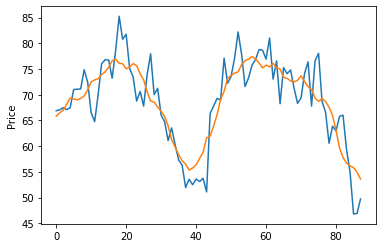

In [228]:
sns.lineplot(y = PriceMA["Price"], x = PriceMA.index)
sns.lineplot(y = PriceMA["MA"], x = PriceMA.index)

In [229]:
UpperPrice = PriceMA[PriceMA.Price >= PriceMA.MA]
LowerPrice = PriceMA[PriceMA.Price < PriceMA.MA]

In [230]:
DemandMA = CMA(demand, "demand", 5)
DemandMA.columns = ["Time", "Demand", "MA"]

                  time  demand
0  2018-01-01 04:30:00    3700
1  2018-01-01 05:00:00    3701
2  2018-01-01 05:30:00    3721
3  2018-01-01 06:00:00    3731
4  2018-01-01 06:30:00    3786
..                 ...     ...
93 2018-01-03 03:00:00    3884
94 2018-01-03 03:30:00    3879
95 2018-01-03 04:00:00    3930
96 2018-01-03 04:30:00    3995
97 2018-01-03 05:00:00    4088

[98 rows x 2 columns]


<AxesSubplot:ylabel='Demand'>

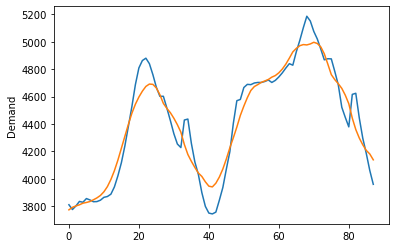

In [231]:
sns.lineplot(y = DemandMA["Demand"], x = DemandMA.index)
sns.lineplot(y = DemandMA["MA"], x = DemandMA.index)

In [232]:
UpperDemand = DemandMA[DemandMA.Demand >= DemandMA.MA]
LowerDemand = DemandMA[DemandMA.Demand < DemandMA.MA]

In [233]:
def intersect(price, demand, status):
    inter = pd.merge(price, demand, on = "Time", how = "inner")
    inter["Status"] = status
    return inter.drop(["MA_x", "MA_y"], axis = 1)

In [234]:
Charge = intersect(LowerPrice, LowerDemand, "Charge")
Discharge = intersect(UpperPrice, UpperDemand, "Discharge")

In [235]:
def BiggerPicture(df, Charge, Discharge):
    cdc = pd.concat([Charge, Discharge], ignore_index = True)

    cdc = cdc[["Time", "Status"]]
    dff = pd.merge(df, cdc, left_on = "Time (UTC+10)", right_on = "Time", how = "left")
    
    return dff[["Time (UTC+10)", "Status"]].replace(np.nan, "Do Nothing")

In [236]:
df = BiggerPicture(df, Charge, Discharge).head(50)
df

,Time (UTC+10),Status
0,2018-01-01 04:30:00,Do Nothing
1,2018-01-01 05:00:00,Do Nothing
2,2018-01-01 05:30:00,Do Nothing
3,2018-01-01 06:00:00,Do Nothing
4,2018-01-01 06:30:00,Do Nothing
5,2018-01-01 07:00:00,Discharge
6,2018-01-01 07:30:00,Do Nothing
7,2018-01-01 08:00:00,Do Nothing
8,2018-01-01 08:30:00,Do Nothing
9,2018-01-01 09:00:00,Do Nothing


In [237]:
dff = pd.merge(df, price, left_on = "Time (UTC+10)", right_on = "time", how = "left").drop('time', axis = 1)
dff

,Time (UTC+10),Status,price
0,2018-01-01 04:30:00,Do Nothing,64.50
1,2018-01-01 05:00:00,Do Nothing,65.41
2,2018-01-01 05:30:00,Do Nothing,63.66
3,2018-01-01 06:00:00,Do Nothing,59.90
4,2018-01-01 06:30:00,Do Nothing,64.67
5,2018-01-01 07:00:00,Discharge,66.89
6,2018-01-01 07:30:00,Do Nothing,67.06
7,2018-01-01 08:00:00,Do Nothing,67.49
8,2018-01-01 08:30:00,Do Nothing,67.12
9,2018-01-01 09:00:00,Do Nothing,67.47


In [243]:
BATTERY_CAPACITY = 580 # maximum capacity MWH
DISCHARGE_EFFICIENCY = 100/90
DISCHARGE_EFFICIENCY_2 = 0.9
CHARGE_EFFICIENCY = 0.9

# steps to calculate revenue

raw_power = 0
opening_capacity = 0
closing_capacity = 0
market_dispatch = 0

raw_power_s = pd.Series(dtype = float)
opening_capacity_s = pd.Series(dtype = float)
closing_capacity_s = pd.Series(dtype = float)
market_dispatch_s = pd.Series(dtype = float)

# current_capacity_s.loc[0] = 1
# calculate market revenue -> need market dispatch
# create market dispatch

status = dff['Status']

for i in dff.index:
    #print(status[i])
    if i == 0:
        opening_capacity_s.loc[i] = 0
    else:
        opening_capacity = closing_capacity_s.loc[i-1]
        # print(opening_capacity)
        opening_capacity_s.loc[i] = closing_capacity_s.loc[i-1]
    if status[i] == 'Charge':
        raw_power = -min(300, (int(BATTERY_CAPACITY) - float(opening_capacity_s[i])) * 2) # 300 is the minimum capacity
        market_dispatch = raw_power/2
        closing_capacity = max(0, min(opening_capacity_s[i] - market_dispatch * CHARGE_EFFICIENCY, BATTERY_CAPACITY))
        print(min(opening_capacity_s[i] - market_dispatch * CHARGE_EFFICIENCY, BATTERY_CAPACITY))
        raw_power_s.loc[i] = raw_power
        market_dispatch_s.loc[i] = market_dispatch
        closing_capacity_s.loc[i] = closing_capacity
        print(raw_power, market_dispatch, opening_capacity, closing_capacity, i)
        #print(current_capacity)
    elif status[i] == 'Discharge':
        #print(i, "inside")
        raw_power = min(300, float(opening_capacity_s[i]) * 2)
        #print(raw_power, print(opening_capacity_s[i]))
        market_dispatch = raw_power/2 * DISCHARGE_EFFICIENCY_2
        closing_capacity = max(0, min(opening_capacity_s[i] - (market_dispatch * DISCHARGE_EFFICIENCY), BATTERY_CAPACITY))
        #print(i, closing_capacity, opening_capacity)
        market_dispatch_s.loc[i] = market_dispatch
        closing_capacity_s.loc[i] = closing_capacity
        raw_power_s.loc[i] = raw_power
        #print(current_capacity)
    else:
        raw_power_s.loc[i] = 0
        market_dispatch_s.loc[i] = 0
        closing_capacity_s.loc[i] = closing_capacity
    
    print('opening:', i, opening_capacity_s.loc[i])
    print('closing:', i, closing_capacity_s.loc[i])
    
print('opening capacity: \n', opening_capacity_s)
print('closing capacity: \n', closing_capacity_s)
print('raw power: \n', raw_power_s)
print('market dispatch: \n', market_dispatch_s)


opening: 0 0
closing: 0 0
opening: 1 0
closing: 1 0
opening: 2 0
closing: 2 0
opening: 3 0
closing: 3 0
opening: 4 0
closing: 4 0
opening: 5 0
closing: 5 0
opening: 6 0
closing: 6 0
opening: 7 0
closing: 7 0
opening: 8 0
closing: 8 0
opening: 9 0
closing: 9 0
opening: 10 0
closing: 10 0
opening: 11 0
closing: 11 0
opening: 12 0
closing: 12 0
opening: 13 0
closing: 13 0
opening: 14 0
closing: 14 0
135.0
-300 -150.0 0 135.0 15
opening: 15 0
closing: 15 135.0
270.0
-300 -150.0 135.0 270.0 16
opening: 16 135.0
closing: 16 270.0
405.0
-300 -150.0 270.0 405.0 17
opening: 17 270.0
closing: 17 405.0
opening: 18 405.0
closing: 18 405.0
opening: 19 405.0
closing: 19 405.0
opening: 20 405.0
closing: 20 405.0
540.0
-300 -150.0 405.0 540.0 21
opening: 21 405.0
closing: 21 540.0
opening: 22 540.0
closing: 22 540.0
opening: 23 540.0
closing: 23 390.0
opening: 24 390.0
closing: 24 240.0
opening: 25 240.0
closing: 25 90.0
opening: 26 90.0
closing: 26 90.0
opening: 27 90.0
closing: 27 90.0
opening: 28 9

In [244]:
dff['raw power'] = raw_power_s
dff['market dispatch'] = market_dispatch_s
dff['opening capacity'] = opening_capacity_s
dff['closing capacity'] = closing_capacity_s

In [255]:
MARGINAL_LOSS_FACTOR = 0.991

revenue_s = pd.Series(dtype = float)
for i in dff.index:
    if dff['market dispatch'].loc[i] < 0:
        revenue_s.loc[i] = dff['price'].loc[i] * dff['market dispatch'].loc[i] * (1 / MARGINAL_LOSS_FACTOR)
    else:
        revenue_s.loc[i] = dff['price'].loc[i] * dff['market dispatch'].loc[i] * (MARGINAL_LOSS_FACTOR)

In [248]:
dff['revenue'] = revenue_s

In [249]:
dff

,Time (UTC+10),Status,price,raw power,market dispatch,opening capacity,closing capacity,revenue
0,2018-01-01 04:30:00,Do Nothing,64.50,0.00,0.00,0.000,0.000,0.000000
1,2018-01-01 05:00:00,Do Nothing,65.41,0.00,0.00,0.000,0.000,0.000000
2,2018-01-01 05:30:00,Do Nothing,63.66,0.00,0.00,0.000,0.000,0.000000
3,2018-01-01 06:00:00,Do Nothing,59.90,0.00,0.00,0.000,0.000,0.000000
4,2018-01-01 06:30:00,Do Nothing,64.67,0.00,0.00,0.000,0.000,0.000000
5,2018-01-01 07:00:00,Discharge,66.89,0.00,0.00,0.000,0.000,0.000000
6,2018-01-01 07:30:00,Do Nothing,67.06,0.00,0.00,0.000,0.000,0.000000
7,2018-01-01 08:00:00,Do Nothing,67.49,0.00,0.00,0.000,0.000,0.000000
8,2018-01-01 08:30:00,Do Nothing,67.12,0.00,0.00,0.000,0.000,0.000000
9,2018-01-01 09:00:00,Do Nothing,67.47,0.00,0.00,0.000,0.000,0.000000


In [253]:
print('total revenue:', sum(dff['revenue']))

total revenue: -42738.04608343089
